# template day note notebook for Ruobing's task

In [84]:
%matplotlib inline
import os     # for getting file paths
import neo    # for reading neural data (TDT format)
import dg2df  # for reading behavioral data
import pandas as pd
import re     # use regular expression to find file names
import numpy as np
import scipy as sp
import math

import misc_tools
import signal_align
import data_load_DLSH
import matplotlib as mpl
import matplotlib.pyplot as plt
import df_ana
import PyNeuroAna as pna
import PyNeuroPlot as pnp
import data_load_DLSH
import GM32_layout
mpl.style.use('ggplot')

## Load data

In [97]:
# Data path settings
dir_tdt_tank = '/shared/lab/projects/encounter/data/TDT/' # Neural data (TDT)
dir_dg = '/shared/lab/projects/analysis/ruobing/data_dg' # Task parameters / behavior data
keyword_tank = '.*Dexter.*GM32-171018.*' # Tank name (common)
keyword_blk = '.*featureMTS' # Task name

In [98]:
# Load data
[blk, data_df, name_tdt_blocks] = data_load_DLSH.load_data(
    keyword_blk, keyword_tank,
    dir_tdt_tank=dir_tdt_tank, dir_dg=dir_dg,
    tf_interactive=False, tf_verbose=True)

filename_common = misc_tools.str_common(name_tdt_blocks)

data_df = data_load_DLSH.standardize_data_df(data_df, filename_common)
blk     = data_load_DLSH.standardize_blk(blk)

ts_StimOn = data_load_DLSH.get_ts_align(blk, data_df, dg_tos_align='stimon') # Stimons in the TDT clock

In [ ]:
# Generate data structure for LFP and spk
window_offset = [-0.4,1.6] # Time window to show
# Realign LFP data to stim-on events
data_neuro_LFP = signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset, 
                                               type_filter='ana.*', name_filter='LFP.*')
# Realign spike data to stim-on events and bin spikes using the same sampling rate with LFP
data_neuro_spk = signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset, 
                                               type_filter='spiketrains.*', name_filter='.*Code[1-9]$',
                                               spike_bin_rate=data_neuro_LFP['signal_info']['sampling_rate'][0]))

## Basics - ERP & PSTH & Tuning

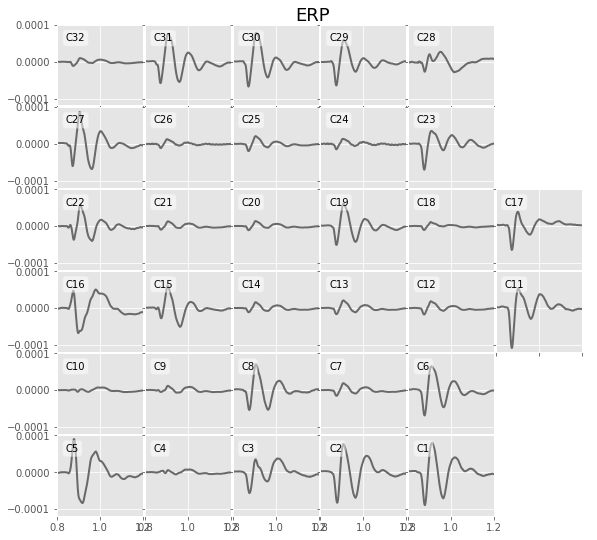

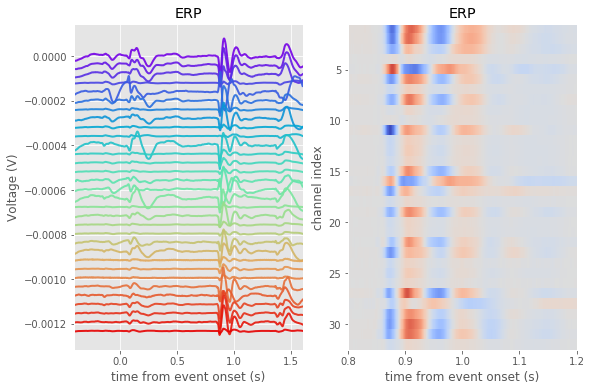

In [130]:
# ERPs of all channels
window_visual = [0.80, 1.20]
# ERPs with array positions (visual onset only)
temp = pnp.ErpPlot(data_neuro_LFP, data_neuro_LFP['ts'], array_layout=GM32_layout.layout_GM32, tlim=window_visual)
# ERPs without position (full time scale)
temp = pnp.ErpPlot(data_neuro_LFP, data_neuro_LFP['ts'])

 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f405701e7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f403a6197f0>], dtype=object)]

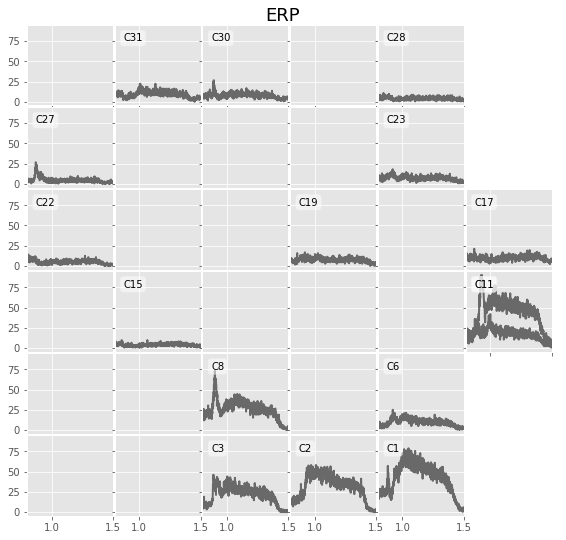

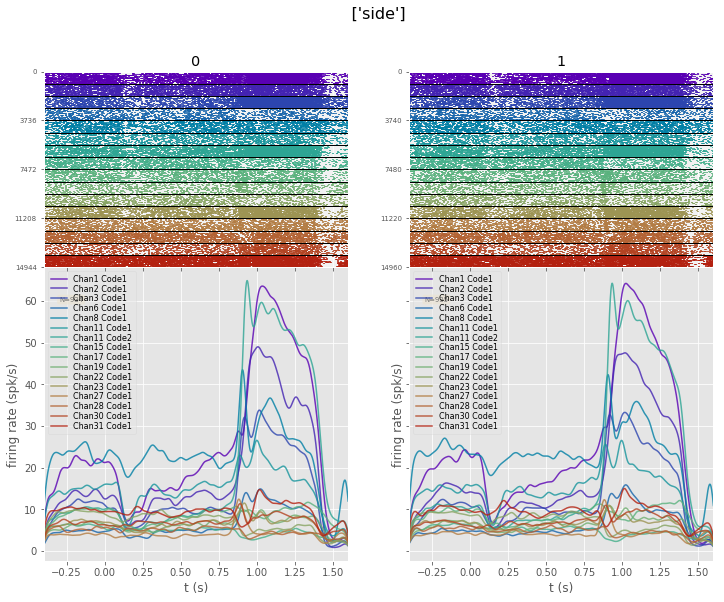

In [149]:
# PSTHs of all channels
window_visual = [0.80, 1.50]
# PSTHs with array positions (visual only)
_ = pnp.ErpPlot(data_neuro_spk, data_neuro_spk['ts'], array_layout=GM32_layout.layout_GM32, tlim=window_visual)
# PSTHs without position (full time scale)
data_neuro_spk = signal_align.neuro_sort(data_df, ['side'], [], data_neuro)
_ = pnp.DataNeuroSummaryPlot(data_neuro_spk, tf_legend=True)

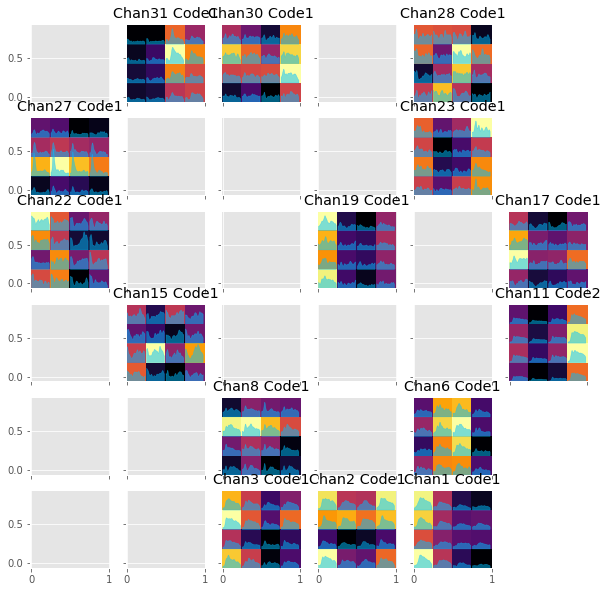

In [142]:
# Plot tuning properties for each channel
data_to_use = 'spk' # two data sources: spk or lfp
data_neuro = data_neuro_spk if data_to_use == 'spk' else data_neuro_LFP
window_trace = [0.8, 1.4] # Time Window to show
window_RF = [0.85, 1.2] # Time window to calculate tuning properties

# Get the number of channels
num_signals = len(data_neuro['signal_info'])

# Define tuning dimensions, 0 = orientation 1 = color
data_df['tuning0'] = data_df['ProbeOrientation']/180
data_df['tuning1'] = data_df['ProbeColor']/np.pi/2

# Sort the aligned data by tuning dimensions
data_neuro = signal_align.neuro_sort(data_df, ['tuning0','tuning1'], [], data_neuro)

# Plot tunings
h_fig, h_axes = pnp.create_array_layout_subplots(GM32_layout.layout_GM32) # Create subplots
h_fig.set_size_inches([10,10])
tuning_all = []
selectivity_type = np.zeros(num_signals) # 0 = orientation, 1 = color
for i_signal in range(num_signals): # for each channel
    index_chan = data_neuro['signal_info']['channel_index'][i_signal]
    plt.axes(h_axes[index_chan-1])
    # Plot receptive field heat map with PSTHs (overlay)
    tuning = pnp.RfPlot(data_neuro, sk_std=0.02, indx_sgnl=i_signal, t_focus=window_RF, tlim=window_trace)
    tuning_all.append(tuning)
    # Record the result tuning type
    if np.mean(np.std(tuning,axis=0)) < np.mean(np.std(tuning,axis=1)):
        selectivity_type[i_signal] = 1
    signal_name = data_neuro['signal_info'][i_signal]['name']
    plt.axis('equal')
    plt.title('{}'.format(signal_name))



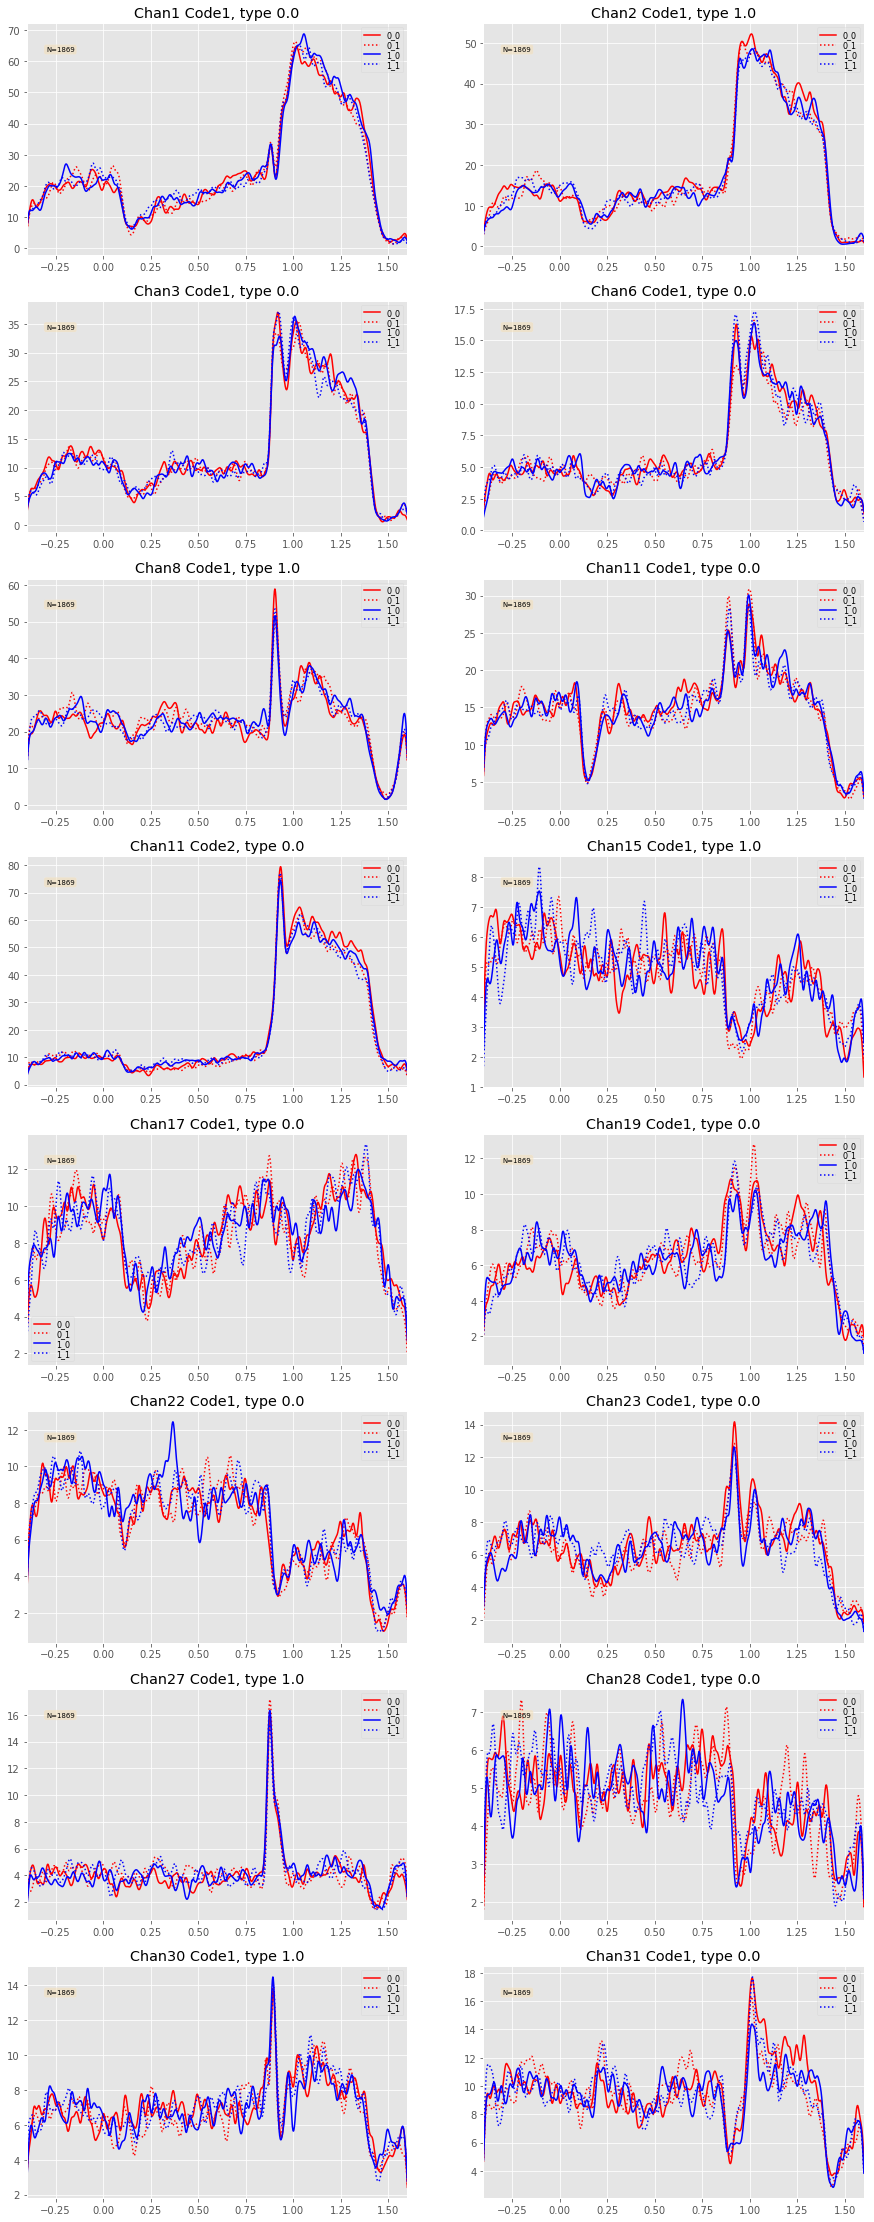

In [143]:
# Sort by task conditions
data_to_use = 'spk' # two data sources: spk or lfp
data_neuro = data_neuro_spk if data_to_use == 'spk' else data_neuro_LFP

# Pick the column names and group data
grpby1 = 'FeatureType'
grpby2 = 'MatchNot'
df_group = df_ana.DfGroupby(data_df, groupby=[grpby1,grpby2], tf_aggregate=False)

# Plot
n_signals = len(data_neuro['signal_info'])
h_fig, h_axes = plt.subplots(math.ceil(n_signals/2),2)
h_fig.set_size_inches([15,math.ceil(n_signals/2)*5])
h_axes = h_axes.flatten()
cdtn = data_df[grpby1].astype('str') + '_' + data_df[grpby2].astype('str') # Combine two task dimensions (grpbys) into one
for i_signal in range(n_signals):
    plt.axes(h_axes[i_signal])
    signal_name = data_neuro['signal_info'][i_signal]['name']
    [h_ax,_] = pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                            cdtn=cdtn, sk_std=0.010, colors=['r','r','b','b'],
                            linestyles=['-',':','-',':'],tf_legend=True, subpanel='')

    
    plt.title('{}, type {}'.format(signal_name, selectivity_type[i_signal]))

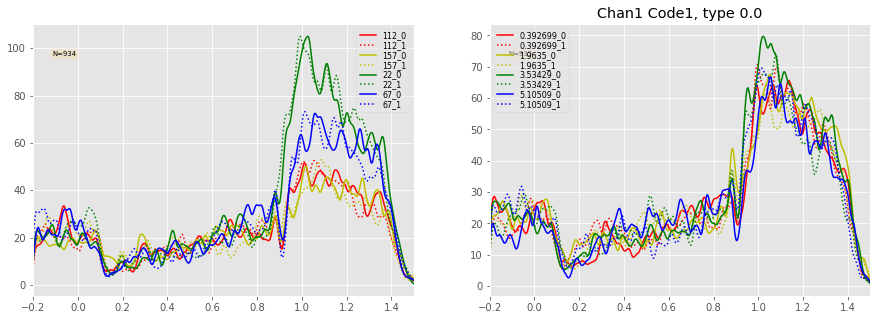

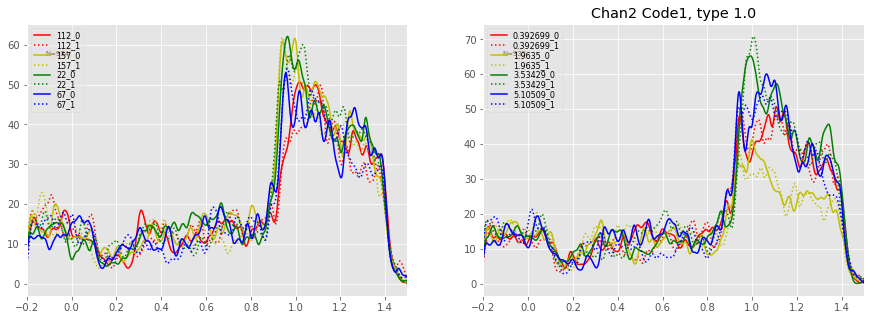

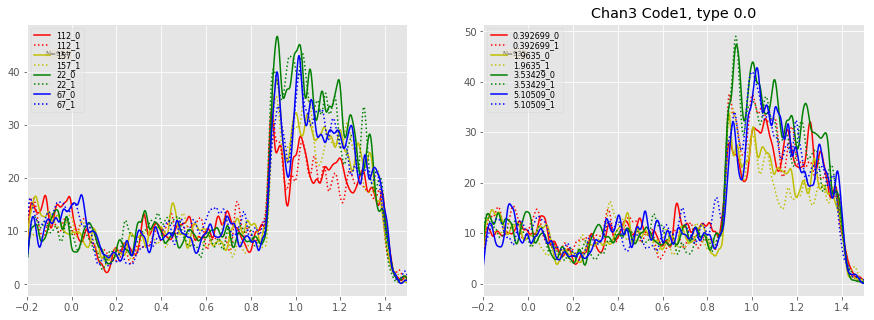

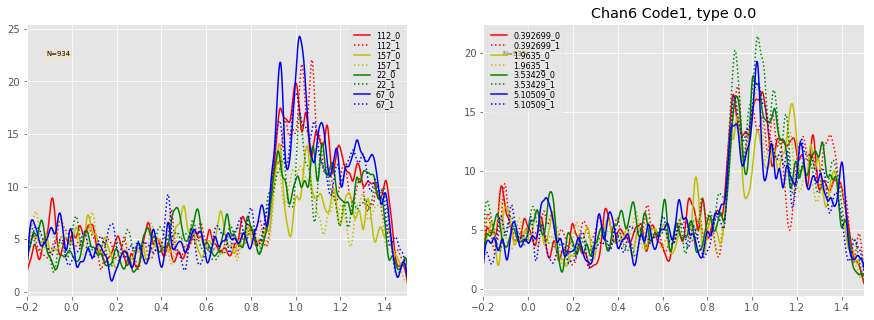

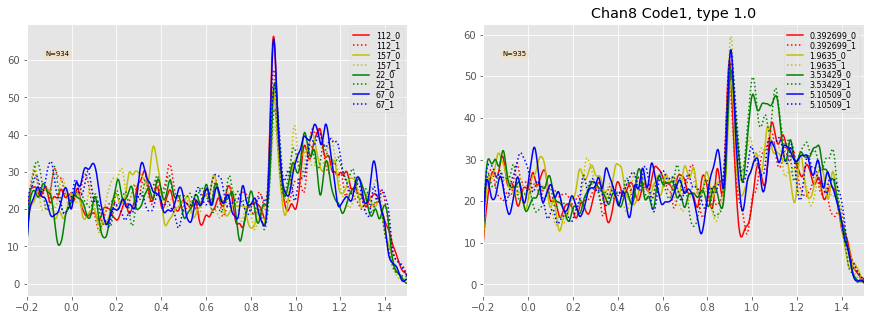

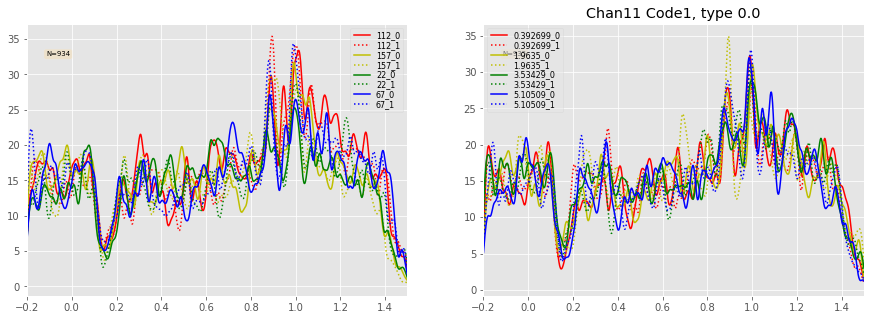

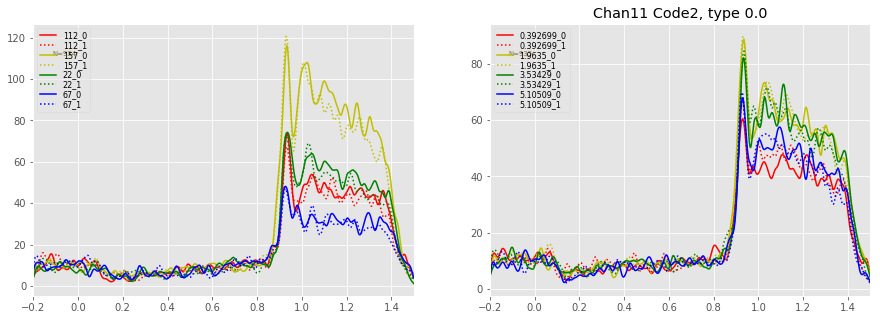

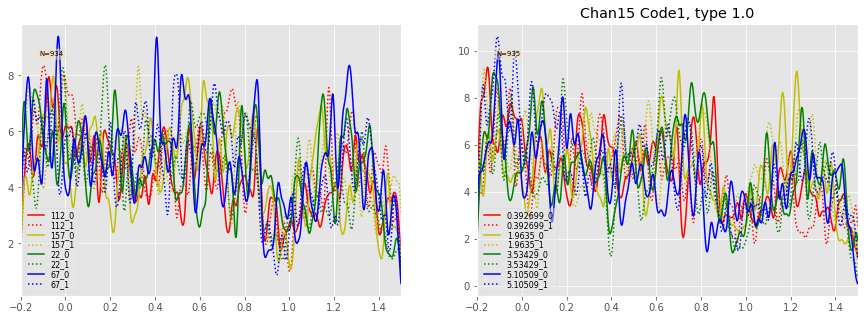

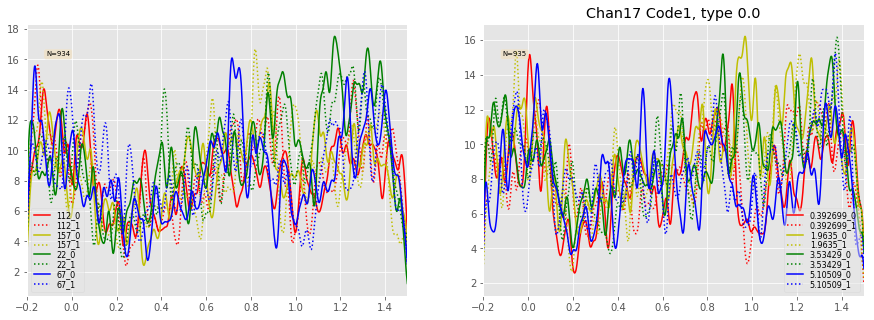

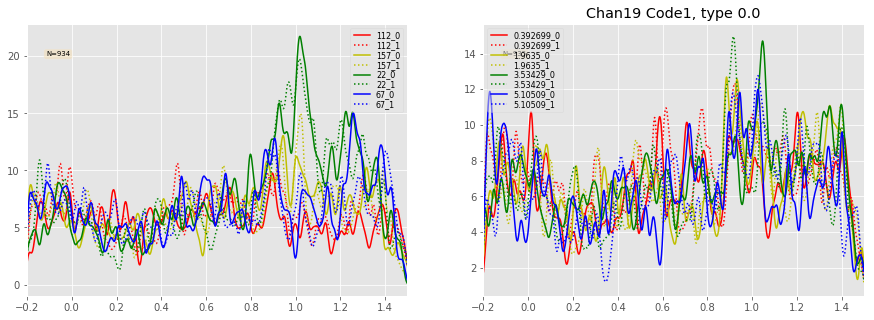

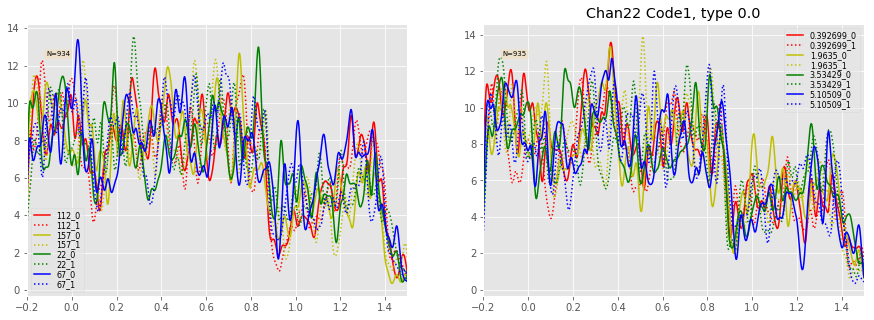

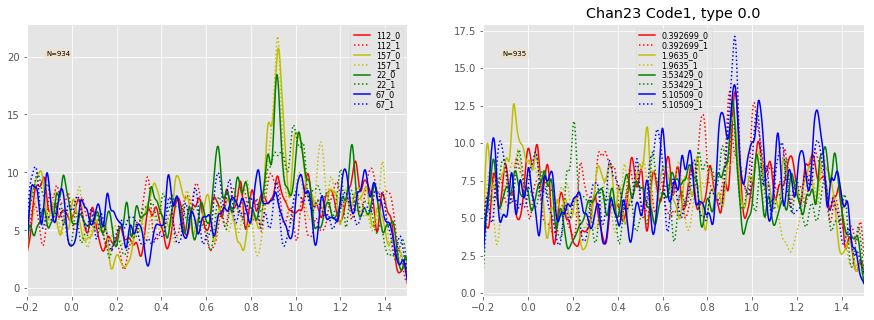

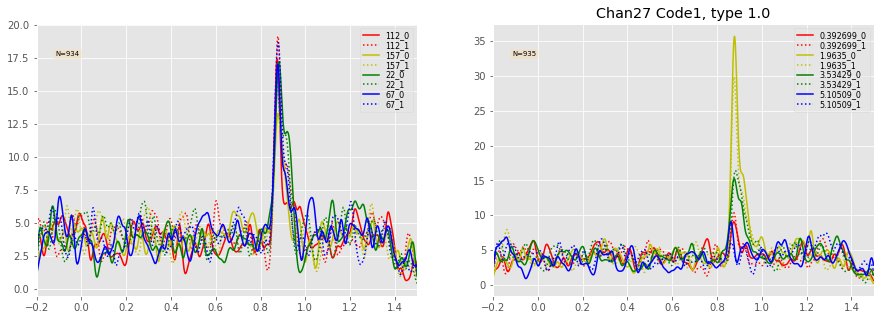

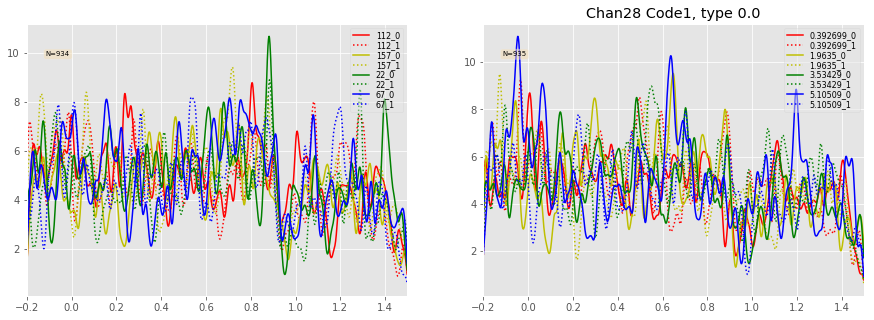

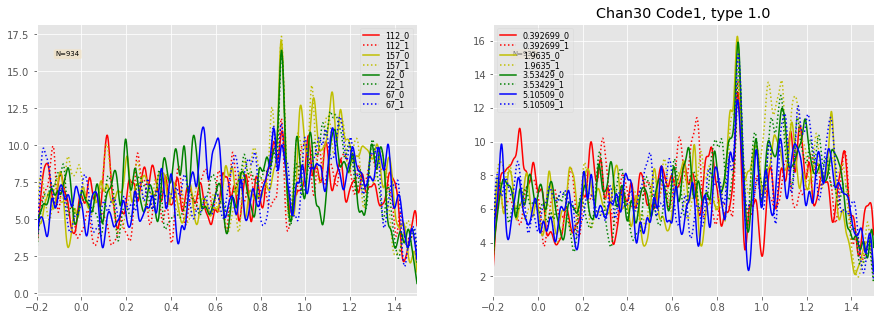

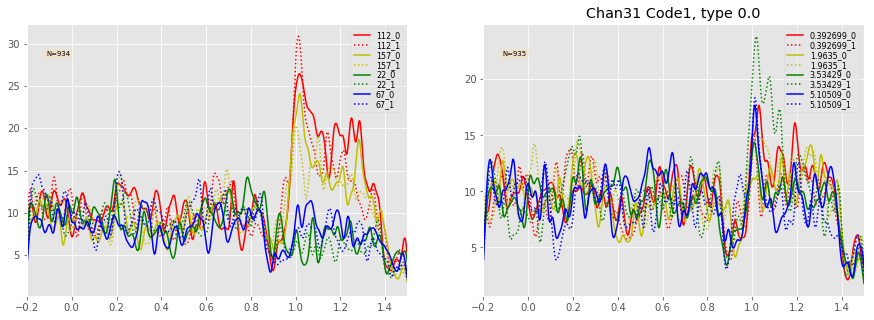

In [112]:
# Sort by probe orientation (left) and probe color (right)
data_to_use = 'spk' # two data sources: spk or lfp
data_neuro = data_neuro_spk if data_to_use == 'spk' else data_neuro_LFP

# Pick the column names and group data
grpby1_0 = 'ProbeOrientation'
grpby1_1 = 'ProbeColor'
grpby2 = 'MatchNot'

# Plot
n_signals = len(data_neuro['signal_info'])
cdtn0 = data_df[grpby1_0].astype('str') + '_' + data_df[grpby2].astype('str') # Combine two task dimensions (grpbys) into one
cdtn1 = data_df[grpby1_1].astype('str') + '_' + data_df[grpby2].astype('str') # Combine two task dimensions (grpbys) into one
for i_signal in range(n_signals):
    signal_name = data_neuro['signal_info'][i_signal]['name']
    plt.figure(figsize=[15,5])
    plt.subplot(1,2,1)
    [h_ax,_] = pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'], cdtn=cdtn0, 
                            limit=data_df['FeatureType']==0, sk_std=0.010, colors=['r','r','y','y','g','g','b','b'], 
                            linestyles=['-',':','-',':','-',':','-',':'],tf_legend=True, subpanel='')    
    plt.subplot(1,2,2)
    [h_ax,_] = pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'], cdtn=cdtn1, 
                            limit=data_df['FeatureType']==1, sk_std=0.010, colors=['r','r','y','y','g','g','b','b'],
                            linestyles=['-',':','-',':','-',':','-',':'],tf_legend=True, subpanel='')

    
    plt.title('{}, type {}'.format(signal_name, selectivity_type[i_signal]))

## LFP spectrum

In [186]:
# Convert the data into mne data structure
import mne

window_offset = [-0.6,1.8] # Time window to consider
# Realign LFP data to stim-on events
data_neuro_LFP = signal_align.blk_align_to_evt(blk, ts_StimOn, window_offset, 
                                               type_filter='ana.*', name_filter='LFP.*')
channels = np.array([1,2,3,5,6,8,11,17,19,22,23,27,28,31]) # pick channels to analyze (removing bad ones)
data_neuro_LFP = signal_align.select_signal(data_neuro_LFP,indx=channels)
fs = data_neuro_LFP['signal_info']['sampling_rate'][0] # Sampling rate info
info = mne.create_info(ch_names=list(data_neuro_LFP['signal_info']['name'].astype('str')), sfreq=fs)
data_mne = mne.EpochsArray(data_neuro_LFP['data'].transpose([0, 2, 1]), info, tmin=data_neuro_LFP['ts'][0])

1869 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [187]:
# Compute single trial spectrogram using wavelet and/or multitaper
freqs = np.arange(3., 80., 1.)
n_cycles = freqs/5
time_bandwidth = 2.0  # Least possible frequency-smoothing (1 taper)
power_mt = mne.time_frequency.tfr_multitaper(data_mne, freqs=freqs, n_cycles=n_cycles,picks=np.arange(14),decim=1,
                       time_bandwidth=time_bandwidth, return_itc=False,average=False)
print('multitaper is done')

multitaper is done


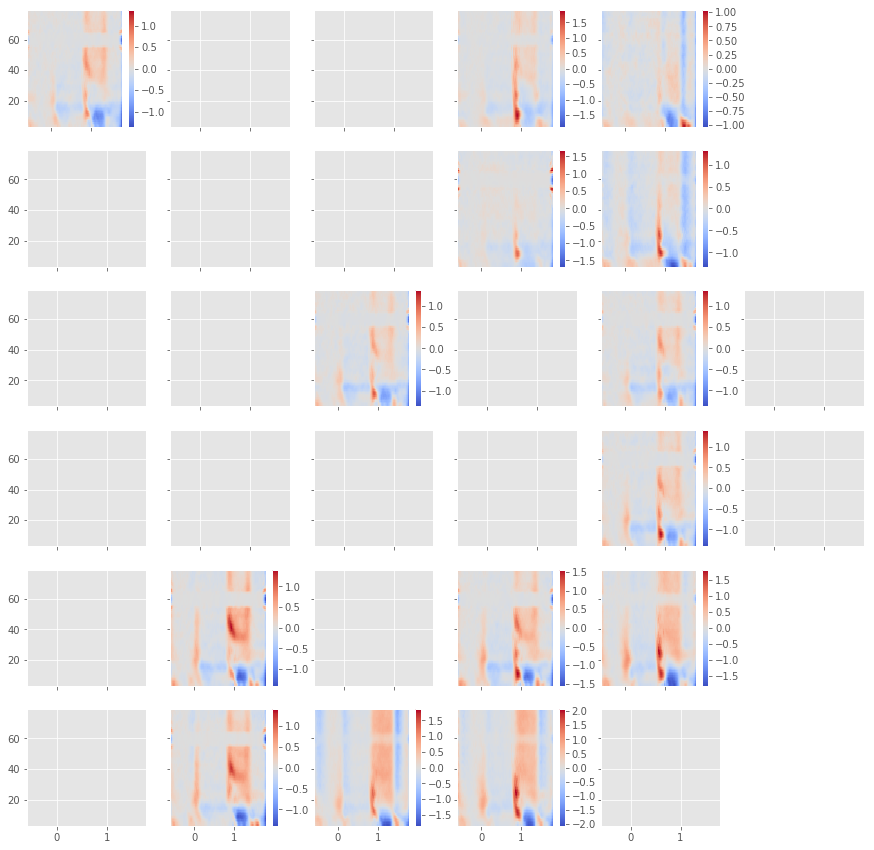

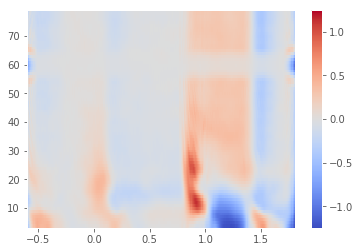

In [207]:
# Plot average spectrum without/with baseline removed
time_baseline = [-0.3,-0.1] # None if not removing baseline
down_sample_every = 10 # Downsample data for faster plotting
h_fig, h_axes = pnp.create_array_layout_subplots(GM32_layout.layout_GM32) # Create subplots
h_fig.set_size_inches([15,15])
num_signals = len(data_neuro_LFP['signal_info'])
spcg_sum = 0
for i_signal in range(num_signals): # for each channel
    index_chan = data_neuro_LFP['signal_info']['channel_index'][i_signal]
    plt.axes(h_axes[index_chan-1])
    spcg = power_mt.data[:,i_signal,:, ::down_sample_every]
    spcg_t = power_mt.times[::down_sample_every]
    pnp.SpectrogramPlot(spcg, spcg_t, power_mt.freqs, limit_trial = None, 
                     tf_phase=False, tf_log=True, time_baseline=time_baseline, tf_colorbar=True)
    spcg_sum += spcg
# Plot the average across channels
plt.figure()
pnp.SpectrogramPlot(spcg_sum/num_signals, spcg_t, power_mt.freqs, limit_trial = None, 
                 tf_phase=False, tf_log=True, time_baseline=time_baseline, tf_colorbar=True)

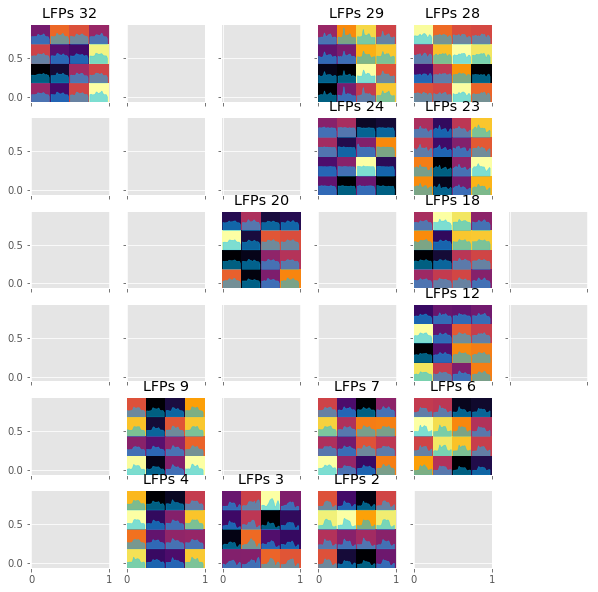

In [220]:
# Plot spectrum defined tunings
window_freq = [30,100]
freqs_in_window = np.logical_and(power_mt.freqs>=window_freq[0],power_mt.freqs<window_freq[1])
data_neuro = data_neuro_LFP
data_neuro['data'] = np.moveaxis(np.mean(power_mt.data[:,:,freqs_in_window,:],axis=2),1,-1)
data_neuro['ts'] = power_mt.times
window_trace = [0.4, 1.8] # Time Window to show
window_RF = [0.9, 1.3] # Time window to calculate tuning properties

# Get the number of channels
num_signals = len(data_neuro['signal_info'])

# Define tuning dimensions, 0 = orientation 1 = color
data_df['tuning0'] = data_df['ProbeOrientation']/180
data_df['tuning1'] = data_df['ProbeColor']/np.pi/2

# Sort the aligned data by tuning dimensions
data_neuro = signal_align.neuro_sort(data_df, ['tuning0','tuning1'], [], data_neuro)

# Plot tunings
h_fig, h_axes = pnp.create_array_layout_subplots(GM32_layout.layout_GM32) # Create subplots
h_fig.set_size_inches([10,10])
tuning_all_spcg = []
selectivity_type = np.zeros(num_signals) # 0 = orientation, 1 = color
for i_signal in range(num_signals): # for each channel
    index_chan = data_neuro['signal_info']['channel_index'][i_signal]
    plt.axes(h_axes[index_chan-1])
    # Plot receptive field heat map with PSTHs (overlay)
    tuning = pnp.RfPlot(data_neuro, sk_std=0.02, indx_sgnl=i_signal, t_focus=window_RF, tlim=window_trace)
    tuning_all_spcg.append(tuning)
    # Record the result tuning type
    if np.mean(np.std(tuning,axis=0)) < np.mean(np.std(tuning,axis=1)):
        selectivity_type[i_signal] = 1
    signal_name = data_neuro['signal_info'][i_signal]['name']
    plt.axis('equal')
    plt.title('{}'.format(signal_name))



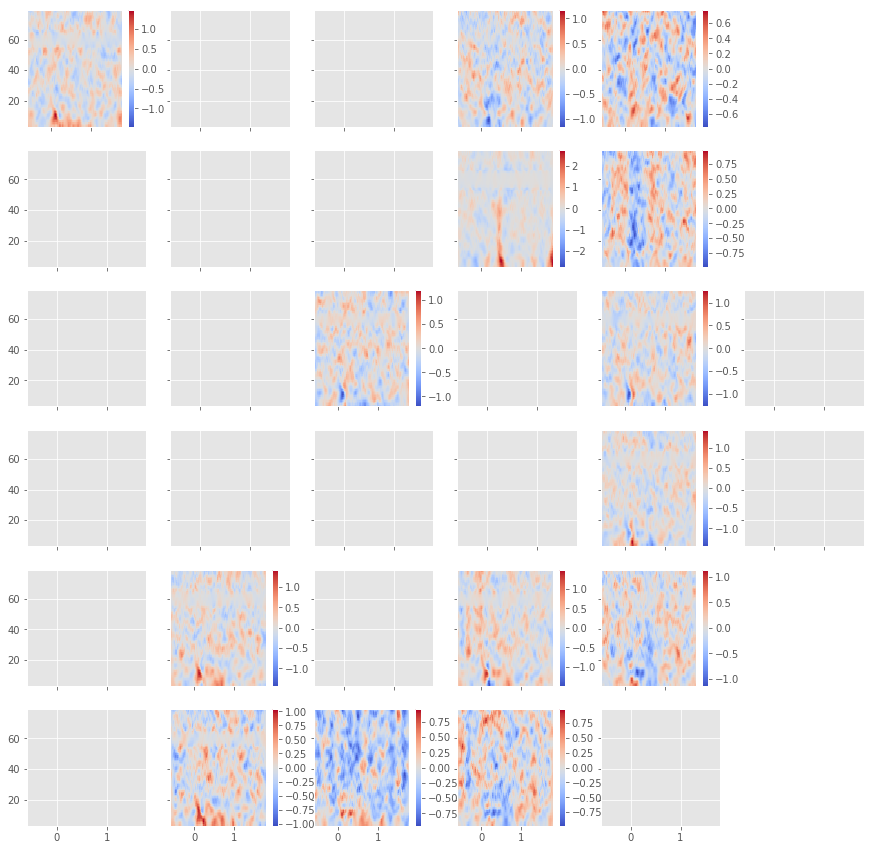

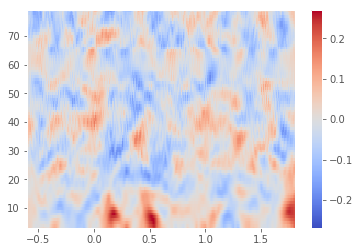

In [223]:
# Plot the difference of spectrum between conditions
groupby_condition = ['FeatureType']
grpby = df_ana.DfGroupby(data_df,groupby=groupby_condition)
grpby_idx0 = list(grpby['idx'].values())[0]
grpby_idx1 = list(grpby['idx'].values())[1]

down_sample_every = 10 # Downsample data for faster plotting
h_fig, h_axes = pnp.create_array_layout_subplots(GM32_layout.layout_GM32) # Create subplots
h_fig.set_size_inches([15,15])
num_signals = len(data_neuro_LFP['signal_info'])
spcg_sum = 0
for i_signal in range(num_signals): # for each channel
    index_chan = data_neuro_LFP['signal_info']['channel_index'][i_signal]
    plt.axes(h_axes[index_chan-1])
    spcg_0 = 10*np.log10(np.mean(power_mt.data[grpby_idx0,i_signal,:,:][:,:,::down_sample_every],axis=0))
    spcg_1 = 10*np.log10(np.mean(power_mt.data[grpby_idx1,i_signal,:,:][:,:,::down_sample_every],axis=0))
    spcg = spcg_1 - spcg_0
    if groupby_condition==['FeatureType'] and selectivity_type[i_signal]==0:
        spcg = -spcg # Always take preferred type - nonpreferred
    spcg_t = power_mt.times[::down_sample_every]
    pnp.SpectrogramPlot(spcg, spcg_t, power_mt.freqs, limit_trial = None, c_lim_style = 'diverge',
                     tf_phase=False, tf_log=False, time_baseline=None, tf_colorbar=True)
    spcg_sum = spcg_sum + spcg 
# Plot the average across channels
plt.figure()
pnp.SpectrogramPlot(spcg_sum/num_signals, spcg_t, power_mt.freqs, limit_trial = None, c_lim_style = 'diverge',
                 tf_phase=False, tf_log=False, time_baseline=None, tf_colorbar=True)

In [250]:
from mne.datasets import sample
from mne.io import Raw
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

# Now we are ready to compute the connectivity in the alpha band. Notice
# from the status messages, how mne-python: 1) reads an epoch from the raw
# file, 2) applies SSP and baseline correction, 3) computes the inverse to
# obtain a source estimate, 4) averages the source estimate to obtain a
# time series for each label, 5) includes the label time series in the
# connectivity computation, and then moves to the next epoch. This
# behaviour is because we are using generators and allows us to
# compute connectivity in computationally efficient manner where the amount
# of memory (RAM) needed is independent from the number of epochs.
fmin = 8.
fmax = 13.
sfreq = data_neuro_LFP['signal_info']['sampling_rate'][0] # Sampling rate info
con_methods = ['coh','ppc','pli','wpli2_debiased']
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    data_mne.get_data(), method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, tmin=0.4, tmax=0.7, faverage=True, mt_adaptive=True, n_jobs=1)
# con is a 3D array, get the connectivity for the first (and only) freq. band
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c[:, :, 0]


Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 91 connections
    using t=0.400s..0.700s for estimation (306 points)
fmin=8.000 Hz corresponds to 2.406 < 5 cycles based on the epoch length 0.301 sec, need at least 0.625 sec epochs or fmin=16.622. Spectrum estimate will be unreliable.
    frequencies: 10.0Hz..10.0Hz (1 points)
    connectivity scores will be averaged for each band
    using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence, PPC, PLI, Debiased WPLI Square
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connec

<ipython-input-250-bd35c97c7ac0>:22: RuntimeWarning: fmin=8.000 Hz corresponds to 2.406 < 5 cycles based on the epoch length 0.301 sec, need at least 0.625 sec epochs or fmin=16.622. Spectrum estimate will be unreliable.
  fmax=fmax, tmin=0.4, tmax=0.7, faverage=True, mt_adaptive=True, n_jobs=1)


    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44


    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing connectivity for epoch 224
    computing connectivity for epoch 225
    computing connectivity for epoch 226
    computing connectivity for epoch 227
    computing connectivity for epoch 228
    computing connectivity for epoch 229
    computing connectivity for epoch 230
    computing connectivity for epoch 231
    computing connectivity for epoch 232
    computing connectivity for epoch 233
    computing connectivity for epoch 234
    computing connectivity for epoch 235
    computing connectivity for epoch 236
    computing connectivity for epoch 237
    computing connectivity for epoch 238
    computing connectivity for epoch 239
    computing connectivity for epoch 240
    computing connectivity for epoch 241
    computing connectivity for epoch 242
    computing connectivity for epoch 243
    computing connectivity for epoch 244
    computing connectivity for epoch 245
    computing co

    computing connectivity for epoch 422
    computing connectivity for epoch 423
    computing connectivity for epoch 424
    computing connectivity for epoch 425
    computing connectivity for epoch 426
    computing connectivity for epoch 427
    computing connectivity for epoch 428
    computing connectivity for epoch 429
    computing connectivity for epoch 430
    computing connectivity for epoch 431
    computing connectivity for epoch 432
    computing connectivity for epoch 433
    computing connectivity for epoch 434
    computing connectivity for epoch 435
    computing connectivity for epoch 436
    computing connectivity for epoch 437
    computing connectivity for epoch 438
    computing connectivity for epoch 439
    computing connectivity for epoch 440
    computing connectivity for epoch 441
    computing connectivity for epoch 442
    computing connectivity for epoch 443
    computing connectivity for epoch 444
    computing connectivity for epoch 445
    computing co

    computing connectivity for epoch 622
    computing connectivity for epoch 623
    computing connectivity for epoch 624
    computing connectivity for epoch 625
    computing connectivity for epoch 626
    computing connectivity for epoch 627
    computing connectivity for epoch 628
    computing connectivity for epoch 629
    computing connectivity for epoch 630
    computing connectivity for epoch 631
    computing connectivity for epoch 632
    computing connectivity for epoch 633
    computing connectivity for epoch 634
    computing connectivity for epoch 635
    computing connectivity for epoch 636
    computing connectivity for epoch 637
    computing connectivity for epoch 638
    computing connectivity for epoch 639
    computing connectivity for epoch 640
    computing connectivity for epoch 641
    computing connectivity for epoch 642
    computing connectivity for epoch 643
    computing connectivity for epoch 644
    computing connectivity for epoch 645
    computing co

    computing connectivity for epoch 822
    computing connectivity for epoch 823
    computing connectivity for epoch 824
    computing connectivity for epoch 825
    computing connectivity for epoch 826
    computing connectivity for epoch 827
    computing connectivity for epoch 828
    computing connectivity for epoch 829
    computing connectivity for epoch 830
    computing connectivity for epoch 831
    computing connectivity for epoch 832
    computing connectivity for epoch 833
    computing connectivity for epoch 834
    computing connectivity for epoch 835
    computing connectivity for epoch 836
    computing connectivity for epoch 837
    computing connectivity for epoch 838
    computing connectivity for epoch 839
    computing connectivity for epoch 840
    computing connectivity for epoch 841
    computing connectivity for epoch 842
    computing connectivity for epoch 843
    computing connectivity for epoch 844
    computing connectivity for epoch 845
    computing co

    computing connectivity for epoch 1022
    computing connectivity for epoch 1023
    computing connectivity for epoch 1024
    computing connectivity for epoch 1025
    computing connectivity for epoch 1026
    computing connectivity for epoch 1027
    computing connectivity for epoch 1028
    computing connectivity for epoch 1029
    computing connectivity for epoch 1030
    computing connectivity for epoch 1031
    computing connectivity for epoch 1032
    computing connectivity for epoch 1033
    computing connectivity for epoch 1034
    computing connectivity for epoch 1035
    computing connectivity for epoch 1036
    computing connectivity for epoch 1037
    computing connectivity for epoch 1038
    computing connectivity for epoch 1039
    computing connectivity for epoch 1040
    computing connectivity for epoch 1041
    computing connectivity for epoch 1042
    computing connectivity for epoch 1043
    computing connectivity for epoch 1044
    computing connectivity for epo

    computing connectivity for epoch 1218
    computing connectivity for epoch 1219
    computing connectivity for epoch 1220
    computing connectivity for epoch 1221
    computing connectivity for epoch 1222
    computing connectivity for epoch 1223
    computing connectivity for epoch 1224
    computing connectivity for epoch 1225
    computing connectivity for epoch 1226
    computing connectivity for epoch 1227
    computing connectivity for epoch 1228
    computing connectivity for epoch 1229
    computing connectivity for epoch 1230
    computing connectivity for epoch 1231
    computing connectivity for epoch 1232
    computing connectivity for epoch 1233
    computing connectivity for epoch 1234
    computing connectivity for epoch 1235
    computing connectivity for epoch 1236
    computing connectivity for epoch 1237
    computing connectivity for epoch 1238
    computing connectivity for epoch 1239
    computing connectivity for epoch 1240
    computing connectivity for epo

    computing connectivity for epoch 1414
    computing connectivity for epoch 1415
    computing connectivity for epoch 1416
    computing connectivity for epoch 1417
    computing connectivity for epoch 1418
    computing connectivity for epoch 1419
    computing connectivity for epoch 1420
    computing connectivity for epoch 1421
    computing connectivity for epoch 1422
    computing connectivity for epoch 1423
    computing connectivity for epoch 1424
    computing connectivity for epoch 1425
    computing connectivity for epoch 1426
    computing connectivity for epoch 1427
    computing connectivity for epoch 1428
    computing connectivity for epoch 1429
    computing connectivity for epoch 1430
    computing connectivity for epoch 1431
    computing connectivity for epoch 1432
    computing connectivity for epoch 1433
    computing connectivity for epoch 1434
    computing connectivity for epoch 1435
    computing connectivity for epoch 1436
    computing connectivity for epo

    computing connectivity for epoch 1610
    computing connectivity for epoch 1611
    computing connectivity for epoch 1612
    computing connectivity for epoch 1613
    computing connectivity for epoch 1614
    computing connectivity for epoch 1615
    computing connectivity for epoch 1616
    computing connectivity for epoch 1617
    computing connectivity for epoch 1618
    computing connectivity for epoch 1619
    computing connectivity for epoch 1620
    computing connectivity for epoch 1621
    computing connectivity for epoch 1622
    computing connectivity for epoch 1623
    computing connectivity for epoch 1624
    computing connectivity for epoch 1625
    computing connectivity for epoch 1626
    computing connectivity for epoch 1627
    computing connectivity for epoch 1628
    computing connectivity for epoch 1629
    computing connectivity for epoch 1630
    computing connectivity for epoch 1631
    computing connectivity for epoch 1632
    computing connectivity for epo

    computing connectivity for epoch 1806
    computing connectivity for epoch 1807
    computing connectivity for epoch 1808
    computing connectivity for epoch 1809
    computing connectivity for epoch 1810
    computing connectivity for epoch 1811
    computing connectivity for epoch 1812
    computing connectivity for epoch 1813
    computing connectivity for epoch 1814
    computing connectivity for epoch 1815
    computing connectivity for epoch 1816
    computing connectivity for epoch 1817
    computing connectivity for epoch 1818
    computing connectivity for epoch 1819
    computing connectivity for epoch 1820
    computing connectivity for epoch 1821
    computing connectivity for epoch 1822
    computing connectivity for epoch 1823
    computing connectivity for epoch 1824
    computing connectivity for epoch 1825
    computing connectivity for epoch 1826
    computing connectivity for epoch 1827
    computing connectivity for epoch 1828
    computing connectivity for epo

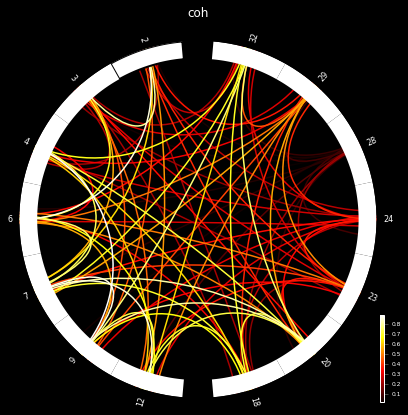

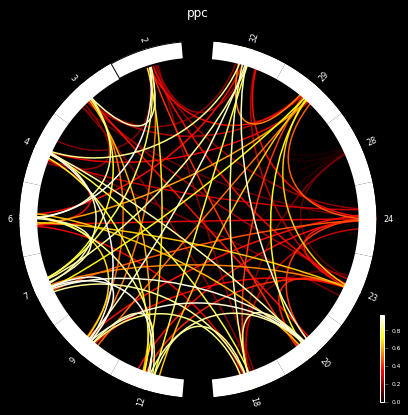

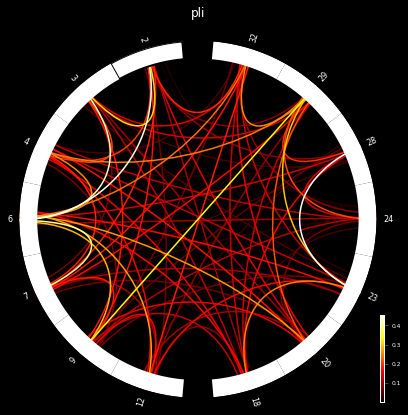

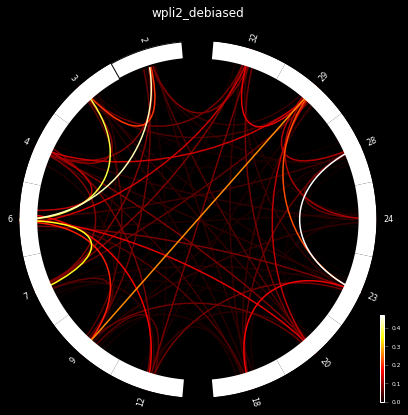

In [254]:
# Now, we visualize the connectivity using a circular graph layout

# First, we reorder the labels based on their location in the left hemi
label_names = list(data_neuro_LFP['signal_info']['channel_index'])

# Save the plot order and create a circular layout
node_order = label_names
node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot connectivity for all methods in the same plot
for ii, method in enumerate(con_methods):
    plot_connectivity_circle(con_res[method], label_names, n_lines=300,
                             node_angles=node_angles, node_colors=[[1,1,1]] * len(label_names),
                             title=method, padding=0, fontsize_colorbar=6)
plt.show()

In [236]:
con_methods = 'wpli2_debiased'
con_res[con_methods] = con[:, :, 0]